In [40]:
import numpy as np
import matplotlib.pyplot as plt

In [41]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()

In [42]:
x = cancer.data
y = cancer.target

In [43]:
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, 
                                                           test_size=0.2, random_state=42)

In [44]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, 
                                                 stratify=y_train_all, test_size=0.2, random_state=42)

In [45]:
class SingleLayer:

    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []       # 추가 05_02
        self.w_history = []        # 추가 05_01
        self.lr = learning_rate    # 추가 05_01, 가중치의 업데이트 양을 조절
                                   # 손실 함수의 표면을 천천히 이동하며 전역 최솟값을 찾는다.
        self.l1 = l1
        self.l2 = l2

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b
        return z

    def backprop(self, x, err):
        w_grad = x * err
        b_grad = 1 * err
        return w_grad, b_grad

    def activation(self, z):
        z = np.clip(z, -100, None)
        a = 1 / (1 + np.exp(-z))
        return a

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):# 검증 세트를 전달받을 수 있도록 매개변수 추가
        self.w = np.ones(x.shape[1])
        self.b = 0
        self.w_history.append(self.w.copy())
        np.random.seed(42)
        for i in range(epochs):
            loss = 0
            # 인덱스를 섞는다
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:                               # 모든 샘플에 대해 반복한다.
                z = self.forpass(x[i])                      # 정방향 계산
                a = self.activation(z)                      # 활성화 함수 적용
                err = -(y[i] - a)                           # 오차 계산
                w_grad, b_grad = self.backprop(x[i], err)   # 역방향 계산
                w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w
                self.w -= self.lr * w_grad                  # 가중치 업데이트(학습률 적용) 
                self.b -= b_grad                            # 절편 업데이트
                # 가중치를 기록한다
                self.w_history.append(self.w.copy())
                # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적한다.
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            # 에포크마다 평균 손실을 저장한다
            self.losses.append(loss/len(y) + self.reg_loss())
            # 검증 세트에 대한 손실을 계산한다
            self.update_val_loss(x_val, y_val)

    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]        
        return np.array(z) > 0

    def score(self, x, y):
        return np.mean(self.predict(x) == y)
    
    # 검증 손실 계산하기
    def update_val_loss(self, x_val, y_val):
        if x_val is None:
            return
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val[i])                       # 정방향 계산
            a = self.activation(z)                           # 활성화 함수 적용
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))    # 손실 함수 
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())
        
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w) + self.l2 / 2 * np.sum(self.w**2))
    
    

In [46]:
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - train_mean) / train_std

In [47]:
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)

In [48]:
x_val_scaled = (x_val - train_mean) / train_std    # 검증 세트를 훈련 세트와 같은 비율로 전처리해야 한다.
layer2.score(x_val_scaled, y_val)

0.967032967032967

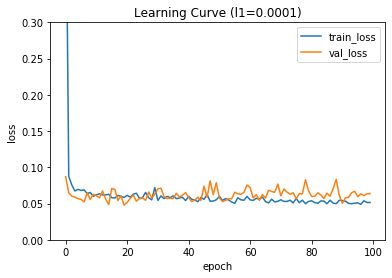

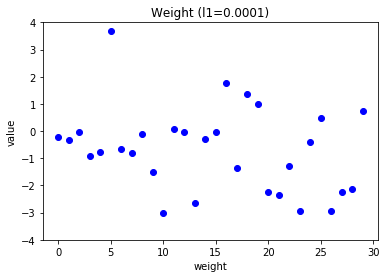

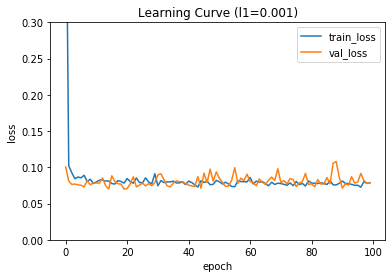

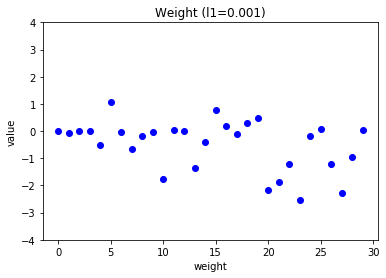

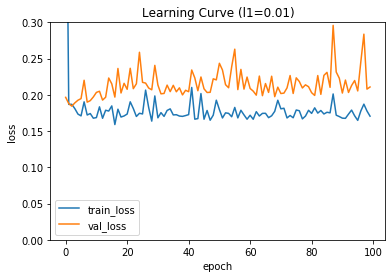

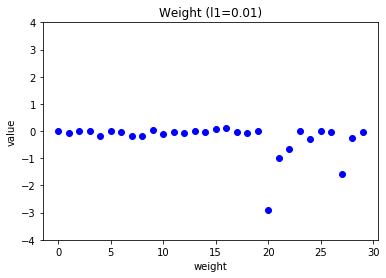

In [49]:
l1_list = [0.0001, 0.001, 0.01]

for l1 in l1_list:
    lyr = SingleLayer(l1=l1)
    lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)
    
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title(f'Learning Curve (l1={l1})')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'])
    plt.ylim(0, 0.3)
    plt.show()
    
    plt.plot(lyr.w, 'bo')
    plt.title(f'Weight (l1={l1})')
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4, 4)
    plt.show()

In [50]:
layer5 = SingleLayer(l1=0.001)
layer5.fit(x_train_scaled, y_train, epochs=20)
layer5.score(x_val_scaled, y_val)

0.978021978021978

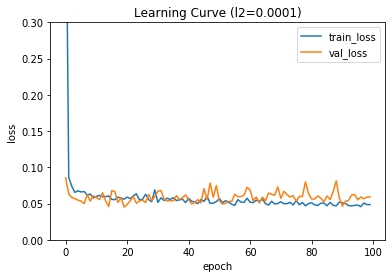

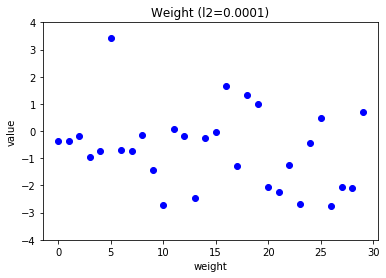

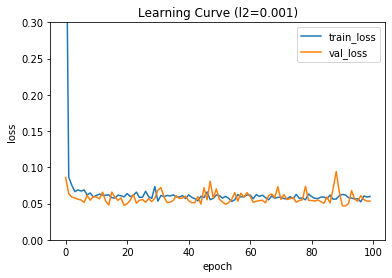

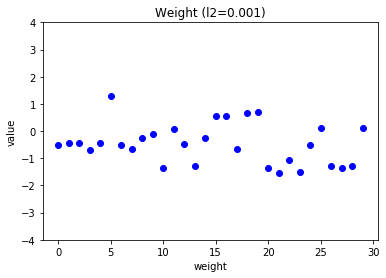

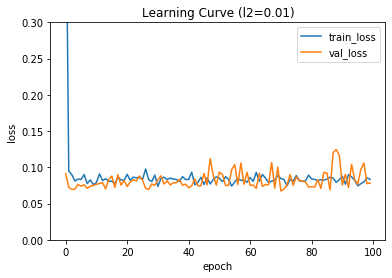

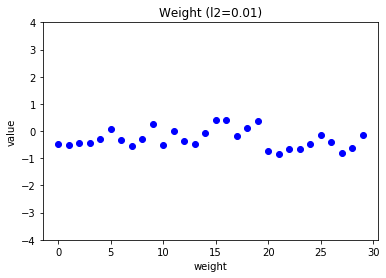

In [51]:
l2_list = [0.0001, 0.001, 0.01]

for l2 in l2_list:
    lyr = SingleLayer(l2=l2)
    lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)
    
    plt.plot(lyr.losses)
    plt.plot(lyr.val_losses)
    plt.title(f'Learning Curve (l2={l2})')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'])
    plt.ylim(0, 0.3)
    plt.show()
    
    plt.plot(lyr.w, 'bo')
    plt.title(f'Weight (l2={l2})')
    plt.ylabel('value')
    plt.xlabel('weight')
    plt.ylim(-4, 4)
    plt.show()

In [58]:
layer6 = SingleLayer(l2=0.01)
layer6.fit(x_train_scaled, y_train, epochs=50)
layer6.score(x_val_scaled, y_val)

0.978021978021978

In [59]:
np.sum(layer6.predict(x_val_scaled) == y_val)

89

In [60]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
sgd.fit(x_train_scaled, y_train)
sgd.score(x_val_scaled, y_val)

0.978021978021978